Logistic regression is very cool and useful, however it is limited to cases with only two classes (i.e. a binary classification problem).  As we discovered before, the sigmoid function is derived directly from the two class expression of Bayes Theorem; perhaps we can find an analogous operation for the multi-class version of Bayes theorem:
$$
P(y_i=C_k|\mathbf{x}_i) = \frac{P(\mathbf{x_i}|y_i=C_k) P(y_i=C_k)}{\sum_{j=1}^N P(\mathbf{x_i}|y_i=C_j) P(y_i=C_j)}.
$$
Unfortunately, we can't write this expression in terms of log-odds, because there is no such thing as odds in the multi-class context (odds being a ratio between two probabilities).  Instead, we can write this expression in terms of log-probabilities
$$
P(y_i=C_k|\mathbf{x}_i) = \frac{\exp a_k}{\sum_{j=1}^N \exp a_j}.
$$
The equation above is known as the **Softmax** function.  It takes as arguments
$$
a_k = \ln P(\mathbf{x_i}|y_i=C_k) P(y_i=C_k).
$$
which are the logarithm of the joint probabilities of the data and the labels.  Just like the sigmoid, it returns a value between 0 and 1 which can be interpreted as a probability.  If we evaluate Softmax for each class of interest, all the resulting values sum to one.  In the event that there are only two classes, the softmax function becomes exactly a sigmoid.  

How do we use the softmax function for classification?  The process again mirrors logistic regression.  We'll model the values $a_k$ as a linear combination of the input values (again, linear in the parameters, not in the features, which can be arbitrarily transformed):
$$
a_k = \mathbf{w}_k \cdot \phi(\mathbf{x}),
$$
where $\mathbf{w}_k$ is a parameter vector associated with class $k$, and $\phi(\mathbf{x})$ is some (possibly enriched) basis set.  In our case, let's just take it to be the feature vector with a one preprepended:
$$
\phi(\mathbf{x}) = [1,x_1,x_2,\ldots,x_n]
$$
However, it could be higher polynomials of the features as well.

As an example, we'll use the iris dataset:

In [147]:
import numpy as np 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16,16]

from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_iris()  
X = data.data
y = data.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

m = X_train.shape[0]              # Number of data points in the training set
N = len(classes)            # Number of classes
n = X_train.shape[1]              # Number of features

# Define class labels
classes = [0,1,2]

def phi(x):
    return np.hstack(([1],x))

Obviously, we need a function that computes softmax of an arbitrary input $a_k$.  However, this gets a little bit tricky, because for a given class we'll need the values of compute $a_k$ for each class in order to compute the denominator.  As such, it really makes more sense to define Softmax as taking as input a vector $\mathbf{a}$ of length $N$, and outputting a vector of length $N$.  In terms of the weights and the features, we can define this vector as 
$$
\mathbf{a} = \phi(x) W
$$,
where $W$ is a $(n+1) \times N$ vector of weights, with columns given by $\mathbf{w}_k$.  For example:

In [163]:
W = np.random.randn(n+1,N)*0.1
phi_1 = phi(X_train[0]).reshape((1,n+1))
a = phi_1 @ W

def softmax(a):
    return np.exp(a)/np.repeat(np.sum(np.exp(a),axis=1,keepdims=True),N,axis=1)

print(softmax(a))

[[0.21604374 0.43518129 0.34877497]]


The resulting values are the probability of each class.  As shorthand, let's call the output of softmax $\theta(\mathbf{x})$ with entries:
$$
\theta_k(\mathbf{x}) = \mathrm{Softmax}_k(\mathbf{a}(\phi(\mathbf{x}),W)).
$$
With a decision strategy, we now have a function that maps from data $\mathbf{x}$ to a class label (for example, classify as the class with the largest probability).

However, all we've done so far is to define a function.  We have yet to fit that function to data.  As with logistic regression, we'll need to adjust the parameters until we maximize our predictive accuracy.  In the two-class case, we defined the likelihood model as a Bernoulli distribution.  Fortunately, there's a multiclass generalization of the Bernoulli called the Multinoulli distribution (or sometimes just multinomial distribution, although this is somewhat more general), which we can use in a similar way.  It's defined as follows:
$$
P(y|\mathbf{x}) = \prod_{k=1}^N \theta_k^{[y=C_k]}.
$$
We can express this somewhat more elegantly if change our data structure for $y$ to a one-hot encoding, which is to say, that we can define a vector $\mathbf{z}$ such that
$$
\mathbf{z} = \begin{cases} [1,0,\ldots,0] & \mathrm{if}\,y=C_1\\
                    [0,1,\ldots,0] & \mathrm{if}\,y=C_2\\
                    \qquad\vdots & \quad \vdots \\
                    [0,0,\ldots,1] & \mathrm{if}\,y=C_N \end{cases}.
                    $$
We have seen this type of construct before, particularly in mixture models.  It's just a different representation of the class membership data.   

In [168]:
def z(y):
    z = np.zeros((N))
    z[y] = 1
    return z
        
z(1)

array([0., 1., 0.])

This gives us a slightly different (but equivalent) definition for the multinoulli:
$$
P(\mathbf{z}|\mathbf{x}) = \prod_{k=1}^N \theta_k(\mathbf{x})^{\mathbf{z}_k}.
$$
This provides us something of misfit function: If $\theta_k$ is large for the correct class, then this number will be large, if $\theta_k$ is small for the correct class, then this number will be small, and so on.  For training purposes, we'll want to maximize this function over all the available training data, which gives us the likelihood model
$$
P(Z|X) = \prod_{i=1}^m \prod_{k=1}^N \Theta_{ik}^{Z_{ik}},
$$
where 
$$
Z = \begin{bmatrix} \mathbf{z}_1 \\
                   \mathbf{z}_2 \\
                   \vdots \\
                   \mathbf{z}_m \end{bmatrix}
$$
and 
$$
\Theta = \begin{bmatrix} \theta_1 \\
                         \theta_2 \\
                         \vdots \\
                         \theta_m
                         \end{bmatrix}
$$
We can compute these matrices easily:

In [172]:
Z = np.vstack([z(y) for y in y_train])
print(Z[:10,:])

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
Phi = np.vstack([phi(x) for x in X_train])
print(Phi[:10])

A = Phi @ W
print(A[:10])

Theta = softmax(A)
print(Theta[:10,:])

Note that these probabilities in $\Theta$ sum to 1, as they must.

In [173]:
Theta.sum(axis=1)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Once again, our likelihood model is 
$$
P(Z|X) = \prod_{i=1}^m \prod_{k=1}^N \Theta_{ik}^{Z_{ik}}.
$$
This distribution is simply the probability of observing our class labels given our data, and also given some model parameters $W$.  in this case, we have a whole bunch of class labels and data, so we'll want to maximize this function with respect to the parameters $W$.  However, it's annoying to maximize products, so instead we'll minimize the negative log-likelihood, which will convert our products to sums.  
$$
\mathcal{L}(Z,X,W) = -\sum_{i=1}^m \sum_{k=1}^N Z_{ik} \ln \Theta_{ik}.
$$

In [174]:
def L(Z,X,W):
    A = np.dot(Phi,W)
    Theta = softmax(A)
    return -np.sum(Z*np.log(Theta))

As before, we can use the derivative of this function with respect to the weights to help find the minimum.  

Taking the derivatives with respect to the weights $W$, we get
$$
\frac{ \partial \mathcal{L}}{\partial W_{jk}} = \sum_{i=1}^m (Z_{ik} - \Theta_{ik})\Phi_{ij}
$$

In [175]:
def _gradient(Phi,W,Z):
    A = np.dot(Phi,W)
    Theta = softmax(A)
    gradW = np.zeros((n+1,N))
    for j in range(n+1):
        for k in range(N):
            for i in range(m):
                gradW[j,k] += (Theta[i,k] - Z[i,k])*Phi[i,j]
    return gradW
_gradient(Phi,W,Z)

array([[ -8.42669373,   7.3274183 ,   1.09927543],
       [-26.35500769,  44.82120038, -18.4661927 ],
       [-35.23877375,  31.00938083,   4.22939292],
       [ 31.98225324,  22.29165973, -54.27391296],
       [ 16.43132988,   9.19970773, -25.6310376 ]])

As before, we can use simple gradient descent to find the minimum.  For gradient descent we need to define a learning rate $\eta$

In [176]:
eta = 0.0001

Now we can loop over a specified number of iterations, and continuously update our weight vector with gradient descent.

In [177]:
N_iterations = 10000
for l in range(N_iterations):
    W -= eta*_gradient(Phi,W,Z)

    y_pred = np.argmax(softmax(np.dot(Phi,W)),axis=1)
    print ('Objective Function Value: ',_L(Phi,W,Z),'Total misclassified: ',sum(y_train!=y_pred))


Objective Function Value:  101.38546678863895 Total misclassified:  65
Objective Function Value:  100.58691792074401 Total misclassified:  66
Objective Function Value:  99.91583716855251 Total misclassified:  80
Objective Function Value:  99.32059438797472 Total misclassified:  82
Objective Function Value:  98.77172991617516 Total misclassified:  73
Objective Function Value:  98.25235463112773 Total misclassified:  66
Objective Function Value:  97.75271847007528 Total misclassified:  60
Objective Function Value:  97.26714251590377 Total misclassified:  57
Objective Function Value:  96.79228227483232 Total misclassified:  51
Objective Function Value:  96.32614034698184 Total misclassified:  48
Objective Function Value:  95.86750212382779 Total misclassified:  45
Objective Function Value:  95.41561133056149 Total misclassified:  42
Objective Function Value:  94.96998226884585 Total misclassified:  42
Objective Function Value:  94.53029041985899 Total misclassified:  39
Objective Function

Objective Function Value:  55.512636241328764 Total misclassified:  15
Objective Function Value:  55.45534876650271 Total misclassified:  15
Objective Function Value:  55.398325633178615 Total misclassified:  15
Objective Function Value:  55.34156459413653 Total misclassified:  15
Objective Function Value:  55.28506342776929 Total misclassified:  15
Objective Function Value:  55.22881993772769 Total misclassified:  15
Objective Function Value:  55.17283195257144 Total misclassified:  15
Objective Function Value:  55.11709732542553 Total misclassified:  15
Objective Function Value:  55.06161393364231 Total misclassified:  15
Objective Function Value:  55.006379678468804 Total misclassified:  15
Objective Function Value:  54.951392484719385 Total misclassified:  15
Objective Function Value:  54.89665030045363 Total misclassified:  15
Objective Function Value:  54.84215109665932 Total misclassified:  15
Objective Function Value:  54.78789286694043 Total misclassified:  15
Objective Functi

Objective Function Value:  46.415391725953576 Total misclassified:  6
Objective Function Value:  46.38830342138638 Total misclassified:  6
Objective Function Value:  46.36127447538744 Total misclassified:  6
Objective Function Value:  46.33430461171342 Total misclassified:  6
Objective Function Value:  46.307393556022106 Total misclassified:  6
Objective Function Value:  46.28054103585587 Total misclassified:  6
Objective Function Value:  46.253746780625335 Total misclassified:  6
Objective Function Value:  46.227010521593186 Total misclassified:  6
Objective Function Value:  46.20033199185813 Total misclassified:  6
Objective Function Value:  46.17371092633907 Total misclassified:  6
Objective Function Value:  46.14714706175942 Total misclassified:  6
Objective Function Value:  46.12064013663153 Total misclassified:  6
Objective Function Value:  46.09418989124135 Total misclassified:  6
Objective Function Value:  46.06779606763322 Total misclassified:  6
Objective Function Value:  46.

Objective Function Value:  43.205077129733446 Total misclassified:  6
Objective Function Value:  43.184094309775745 Total misclassified:  6
Objective Function Value:  43.16314584179262 Total misclassified:  6
Objective Function Value:  43.14223160546081 Total misclassified:  6
Objective Function Value:  43.121351481114836 Total misclassified:  6
Objective Function Value:  43.10050534974241 Total misclassified:  6
Objective Function Value:  43.07969309297984 Total misclassified:  6
Objective Function Value:  43.05891459310738 Total misclassified:  6
Objective Function Value:  43.03816973304483 Total misclassified:  6
Objective Function Value:  43.017458396346925 Total misclassified:  6
Objective Function Value:  42.99678046719899 Total misclassified:  6
Objective Function Value:  42.97613583041241 Total misclassified:  6
Objective Function Value:  42.95552437142038 Total misclassified:  6
Objective Function Value:  42.9349459762735 Total misclassified:  6
Objective Function Value:  42.9

Objective Function Value:  40.81566377422156 Total misclassified:  5
Objective Function Value:  40.79821416291579 Total misclassified:  5
Objective Function Value:  40.78078779282092 Total misclassified:  5
Objective Function Value:  40.76338459940803 Total misclassified:  5
Objective Function Value:  40.74600451843943 Total misclassified:  5
Objective Function Value:  40.72864748596693 Total misclassified:  5
Objective Function Value:  40.71131343833008 Total misclassified:  5
Objective Function Value:  40.69400231215448 Total misclassified:  5
Objective Function Value:  40.67671404435005 Total misclassified:  5
Objective Function Value:  40.65944857210937 Total misclassified:  5
Objective Function Value:  40.64220583290597 Total misclassified:  5
Objective Function Value:  40.62498576449268 Total misclassified:  5
Objective Function Value:  40.607788304899984 Total misclassified:  5
Objective Function Value:  40.590613392434335 Total misclassified:  5
Objective Function Value:  40.57

Objective Function Value:  38.751694992439056 Total misclassified:  5
Objective Function Value:  38.736779440032194 Total misclassified:  5
Objective Function Value:  38.72188075251447 Total misclassified:  5
Objective Function Value:  38.70699889186332 Total misclassified:  5
Objective Function Value:  38.6921338201991 Total misclassified:  5
Objective Function Value:  38.67728549978438 Total misclassified:  5
Objective Function Value:  38.662453893023226 Total misclassified:  5
Objective Function Value:  38.64763896246042 Total misclassified:  5
Objective Function Value:  38.63284067078083 Total misclassified:  5
Objective Function Value:  38.6180589808086 Total misclassified:  5
Objective Function Value:  38.603293855506465 Total misclassified:  5
Objective Function Value:  38.58854525797513 Total misclassified:  5
Objective Function Value:  38.573813151452406 Total misclassified:  5
Objective Function Value:  38.55909749931267 Total misclassified:  5
Objective Function Value:  38.5

Objective Function Value:  37.00710446359169 Total misclassified:  5
Objective Function Value:  36.99404159276132 Total misclassified:  5
Objective Function Value:  36.98099174634645 Total misclassified:  5
Objective Function Value:  36.96795489969376 Total misclassified:  5
Objective Function Value:  36.954931028228316 Total misclassified:  5
Objective Function Value:  36.94192010745319 Total misclassified:  5
Objective Function Value:  36.928922112949095 Total misclassified:  5
Objective Function Value:  36.91593702037406 Total misclassified:  5
Objective Function Value:  36.902964805463085 Total misclassified:  5
Objective Function Value:  36.89000544402779 Total misclassified:  5
Objective Function Value:  36.87705891195607 Total misclassified:  5
Objective Function Value:  36.86412518521176 Total misclassified:  5
Objective Function Value:  36.851204239834324 Total misclassified:  5
Objective Function Value:  36.83829605193846 Total misclassified:  5
Objective Function Value:  36.

Objective Function Value:  35.35246523824256 Total misclassified:  5
Objective Function Value:  35.34096504552201 Total misclassified:  5
Objective Function Value:  35.32947513910951 Total misclassified:  5
Objective Function Value:  35.317995502398446 Total misclassified:  5
Objective Function Value:  35.306526118826774 Total misclassified:  5
Objective Function Value:  35.295066971876835 Total misclassified:  5
Objective Function Value:  35.28361804507519 Total misclassified:  5
Objective Function Value:  35.27217932199244 Total misclassified:  5
Objective Function Value:  35.26075078624306 Total misclassified:  5
Objective Function Value:  35.249332421485235 Total misclassified:  5
Objective Function Value:  35.237924211420705 Total misclassified:  5
Objective Function Value:  35.226526139794544 Total misclassified:  5
Objective Function Value:  35.21513819039504 Total misclassified:  5
Objective Function Value:  35.20376034705353 Total misclassified:  5
Objective Function Value:  3

Objective Function Value:  33.9382109521688 Total misclassified:  4
Objective Function Value:  33.92792292770371 Total misclassified:  4
Objective Function Value:  33.917643350871174 Total misclassified:  4
Objective Function Value:  33.90737220966346 Total misclassified:  4
Objective Function Value:  33.89710949210059 Total misclassified:  4
Objective Function Value:  33.88685518623025 Total misclassified:  4
Objective Function Value:  33.87660928012768 Total misclassified:  4
Objective Function Value:  33.86637176189561 Total misclassified:  4
Objective Function Value:  33.85614261966411 Total misclassified:  4
Objective Function Value:  33.84592184159058 Total misclassified:  4
Objective Function Value:  33.83570941585959 Total misclassified:  4
Objective Function Value:  33.825505330682816 Total misclassified:  4
Objective Function Value:  33.81530957429894 Total misclassified:  4
Objective Function Value:  33.80512213497356 Total misclassified:  4
Objective Function Value:  33.794

Objective Function Value:  32.65831423567188 Total misclassified:  4
Objective Function Value:  32.64903977278246 Total misclassified:  4
Objective Function Value:  32.639772390577576 Total misclassified:  4
Objective Function Value:  32.63051208001182 Total misclassified:  4
Objective Function Value:  32.621258832058 Total misclassified:  4
Objective Function Value:  32.61201263770715 Total misclassified:  4
Objective Function Value:  32.602773487968484 Total misclassified:  4
Objective Function Value:  32.59354137386928 Total misclassified:  4
Objective Function Value:  32.584316286454886 Total misclassified:  4
Objective Function Value:  32.57509821678863 Total misclassified:  4
Objective Function Value:  32.5658871559518 Total misclassified:  4
Objective Function Value:  32.55668309504355 Total misclassified:  4
Objective Function Value:  32.547486025180895 Total misclassified:  4
Objective Function Value:  32.53829593749858 Total misclassified:  4
Objective Function Value:  32.529

Objective Function Value:  31.12761233893656 Total misclassified:  4
Objective Function Value:  31.119459235874782 Total misclassified:  4
Objective Function Value:  31.11131186120653 Total misclassified:  4
Objective Function Value:  31.10317020842021 Total misclassified:  4
Objective Function Value:  31.095034271015464 Total misclassified:  4
Objective Function Value:  31.08690404250316 Total misclassified:  4
Objective Function Value:  31.07877951640536 Total misclassified:  4
Objective Function Value:  31.070660686255287 Total misclassified:  4
Objective Function Value:  31.062547545597276 Total misclassified:  4
Objective Function Value:  31.0544400879868 Total misclassified:  4
Objective Function Value:  31.046338306990386 Total misclassified:  4
Objective Function Value:  31.03824219618562 Total misclassified:  4
Objective Function Value:  31.030151749161096 Total misclassified:  4
Objective Function Value:  31.02206695951642 Total misclassified:  4
Objective Function Value:  31

Objective Function Value:  30.20343284901078 Total misclassified:  4
Objective Function Value:  30.195913545902336 Total misclassified:  4
Objective Function Value:  30.18839927353297 Total misclassified:  4
Objective Function Value:  30.180890026544752 Total misclassified:  4
Objective Function Value:  30.173385799588196 Total misclassified:  4
Objective Function Value:  30.165886587322298 Total misclassified:  4
Objective Function Value:  30.158392384414448 Total misclassified:  4
Objective Function Value:  30.15090318554045 Total misclassified:  4
Objective Function Value:  30.14341898538449 Total misclassified:  4
Objective Function Value:  30.135939778639127 Total misclassified:  4
Objective Function Value:  30.12846556000527 Total misclassified:  4
Objective Function Value:  30.120996324192145 Total misclassified:  4
Objective Function Value:  30.113532065917298 Total misclassified:  4
Objective Function Value:  30.10607277990657 Total misclassified:  4
Objective Function Value: 

Objective Function Value:  29.335597271465453 Total misclassified:  4
Objective Function Value:  29.328645629936144 Total misclassified:  4
Objective Function Value:  29.321698431641067 Total misclassified:  4
Objective Function Value:  29.31475567211493 Total misclassified:  4
Objective Function Value:  29.307817346898926 Total misclassified:  4
Objective Function Value:  29.300883451540763 Total misclassified:  4
Objective Function Value:  29.29395398159465 Total misclassified:  4
Objective Function Value:  29.287028932621233 Total misclassified:  4
Objective Function Value:  29.28010830018766 Total misclassified:  4
Objective Function Value:  29.273192079867492 Total misclassified:  4
Objective Function Value:  29.266280267240752 Total misclassified:  4
Objective Function Value:  29.259372857893855 Total misclassified:  4
Objective Function Value:  29.252469847419647 Total misclassified:  4
Objective Function Value:  29.24557123141735 Total misclassified:  4
Objective Function Value

Objective Function Value:  28.538374573004212 Total misclassified:  4
Objective Function Value:  28.53192200824987 Total misclassified:  4
Objective Function Value:  28.52547339767108 Total misclassified:  4
Objective Function Value:  28.519028737492246 Total misclassified:  4
Objective Function Value:  28.512588023942914 Total misclassified:  4
Objective Function Value:  28.506151253257777 Total misclassified:  4
Objective Function Value:  28.499718421676626 Total misclassified:  4
Objective Function Value:  28.49328952544438 Total misclassified:  4
Objective Function Value:  28.48686456081106 Total misclassified:  4
Objective Function Value:  28.48044352403176 Total misclassified:  4
Objective Function Value:  28.474026411366676 Total misclassified:  4
Objective Function Value:  28.467613219081066 Total misclassified:  4
Objective Function Value:  28.461203943445263 Total misclassified:  4
Objective Function Value:  28.454798580734625 Total misclassified:  4
Objective Function Value:

Objective Function Value:  27.773279369941665 Total misclassified:  3
Objective Function Value:  27.76728631242079 Total misclassified:  3
Objective Function Value:  27.76129678049824 Total misclassified:  3
Objective Function Value:  27.755310770964243 Total misclassified:  3
Objective Function Value:  27.749328280613142 Total misclassified:  3
Objective Function Value:  27.74334930624336 Total misclassified:  3
Objective Function Value:  27.737373844657434 Total misclassified:  3
Objective Function Value:  27.731401892661967 Total misclassified:  3
Objective Function Value:  27.725433447067648 Total misclassified:  3
Objective Function Value:  27.719468504689218 Total misclassified:  3
Objective Function Value:  27.713507062345492 Total misclassified:  3
Objective Function Value:  27.707549116859344 Total misclassified:  3
Objective Function Value:  27.701594665057687 Total misclassified:  3
Objective Function Value:  27.695643703771474 Total misclassified:  3
Objective Function Valu

Objective Function Value:  26.518626223691797 Total misclassified:  3
Objective Function Value:  26.513346752188852 Total misclassified:  3
Objective Function Value:  26.508070180471236 Total misclassified:  3
Objective Function Value:  26.502796506092725 Total misclassified:  3
Objective Function Value:  26.497525726609926 Total misclassified:  3
Objective Function Value:  26.492257839582294 Total misclassified:  3
Objective Function Value:  26.486992842572107 Total misclassified:  3
Objective Function Value:  26.48173073314448 Total misclassified:  3
Objective Function Value:  26.47647150886735 Total misclassified:  3
Objective Function Value:  26.471215167311463 Total misclassified:  3
Objective Function Value:  26.465961706050393 Total misclassified:  3
Objective Function Value:  26.46071112266051 Total misclassified:  3
Objective Function Value:  26.455463414721017 Total misclassified:  3
Objective Function Value:  26.450218579813885 Total misclassified:  3
Objective Function Valu

Objective Function Value:  25.579304456215112 Total misclassified:  3
Objective Function Value:  25.574527547245328 Total misclassified:  3
Objective Function Value:  25.569753125713397 Total misclassified:  3
Objective Function Value:  25.564981189636455 Total misclassified:  3
Objective Function Value:  25.560211737033807 Total misclassified:  3
Objective Function Value:  25.555444765926907 Total misclassified:  3
Objective Function Value:  25.55068027433935 Total misclassified:  3
Objective Function Value:  25.54591826029688 Total misclassified:  3
Objective Function Value:  25.541158721827358 Total misclassified:  3
Objective Function Value:  25.53640165696083 Total misclassified:  3
Objective Function Value:  25.53164706372943 Total misclassified:  3
Objective Function Value:  25.526894940167445 Total misclassified:  3
Objective Function Value:  25.522145284311286 Total misclassified:  3
Objective Function Value:  25.517398094199503 Total misclassified:  3
Objective Function Value

Objective Function Value:  24.666634079342092 Total misclassified:  3
Objective Function Value:  24.662319971808692 Total misclassified:  3
Objective Function Value:  24.658007992688386 Total misclassified:  3
Objective Function Value:  24.653698140376235 Total misclassified:  3
Objective Function Value:  24.649390413268918 Total misclassified:  3
Objective Function Value:  24.64508480976476 Total misclassified:  3
Objective Function Value:  24.640781328263724 Total misclassified:  3
Objective Function Value:  24.636479967167386 Total misclassified:  3
Objective Function Value:  24.632180724878953 Total misclassified:  3
Objective Function Value:  24.62788359980326 Total misclassified:  3
Objective Function Value:  24.62358859034677 Total misclassified:  3
Objective Function Value:  24.61929569491756 Total misclassified:  3
Objective Function Value:  24.61500491192532 Total misclassified:  3
Objective Function Value:  24.61071623978137 Total misclassified:  3
Objective Function Value: 

Objective Function Value:  24.08267434992836 Total misclassified:  3
Objective Function Value:  24.078643304596962 Total misclassified:  3
Objective Function Value:  24.074614177989623 Total misclassified:  3
Objective Function Value:  24.07058696871094 Total misclassified:  3
Objective Function Value:  24.066561675366902 Total misclassified:  3
Objective Function Value:  24.062538296564853 Total misclassified:  3
Objective Function Value:  24.058516830913476 Total misclassified:  3
Objective Function Value:  24.054497277022854 Total misclassified:  3
Objective Function Value:  24.050479633504402 Total misclassified:  3
Objective Function Value:  24.046463898970913 Total misclassified:  3
Objective Function Value:  24.042450072036512 Total misclassified:  3
Objective Function Value:  24.038438151316704 Total misclassified:  3
Objective Function Value:  24.03442813542833 Total misclassified:  3
Objective Function Value:  24.030420022989585 Total misclassified:  3
Objective Function Valu

Objective Function Value:  23.593233263013296 Total misclassified:  3
Objective Function Value:  23.58943166211627 Total misclassified:  3
Objective Function Value:  23.585631815590382 Total misclassified:  3
Objective Function Value:  23.58183372219859 Total misclassified:  3
Objective Function Value:  23.578037380705016 Total misclassified:  3
Objective Function Value:  23.574242789874962 Total misclassified:  3
Objective Function Value:  23.570449948474902 Total misclassified:  3
Objective Function Value:  23.566658855272458 Total misclassified:  3
Objective Function Value:  23.56286950903644 Total misclassified:  3
Objective Function Value:  23.5590819085368 Total misclassified:  3
Objective Function Value:  23.555296052544684 Total misclassified:  3
Objective Function Value:  23.551511939832373 Total misclassified:  3
Objective Function Value:  23.547729569173313 Total misclassified:  3
Objective Function Value:  23.543948939342133 Total misclassified:  3
Objective Function Value:

Objective Function Value:  23.13124749102773 Total misclassified:  3
Objective Function Value:  23.12765595855812 Total misclassified:  3
Objective Function Value:  23.124066034481395 Total misclassified:  3
Objective Function Value:  23.1204777176967 Total misclassified:  3
Objective Function Value:  23.116891007104158 Total misclassified:  3
Objective Function Value:  23.113305901604917 Total misclassified:  3
Objective Function Value:  23.10972240010112 Total misclassified:  3
Objective Function Value:  23.106140501495922 Total misclassified:  3
Objective Function Value:  23.102560204693503 Total misclassified:  3
Objective Function Value:  23.098981508599017 Total misclassified:  3
Objective Function Value:  23.09540441211864 Total misclassified:  3
Objective Function Value:  23.091828914159546 Total misclassified:  3
Objective Function Value:  23.088255013629915 Total misclassified:  3
Objective Function Value:  23.084682709438916 Total misclassified:  3
Objective Function Value: 

Objective Function Value:  22.694430699197543 Total misclassified:  3
Objective Function Value:  22.69103199413693 Total misclassified:  3
Objective Function Value:  22.687634767333634 Total misclassified:  3
Objective Function Value:  22.684239017804494 Total misclassified:  3
Objective Function Value:  22.680844744567235 Total misclassified:  3
Objective Function Value:  22.677451946640453 Total misclassified:  3
Objective Function Value:  22.674060623043605 Total misclassified:  3
Objective Function Value:  22.670670772797052 Total misclassified:  3
Objective Function Value:  22.66728239492199 Total misclassified:  3
Objective Function Value:  22.663895488440524 Total misclassified:  3
Objective Function Value:  22.660510052375585 Total misclassified:  3
Objective Function Value:  22.657126085751017 Total misclassified:  3
Objective Function Value:  22.653743587591507 Total misclassified:  3
Objective Function Value:  22.650362556922605 Total misclassified:  3
Objective Function Val

Objective Function Value:  22.283967562959603 Total misclassified:  3
Objective Function Value:  22.280744926954156 Total misclassified:  3
Objective Function Value:  22.277523653681122 Total misclassified:  3
Objective Function Value:  22.274303742258866 Total misclassified:  3
Objective Function Value:  22.271085191806478 Total misclassified:  3
Objective Function Value:  22.267868001443844 Total misclassified:  3
Objective Function Value:  22.264652170291594 Total misclassified:  3
Objective Function Value:  22.26143769747112 Total misclassified:  3
Objective Function Value:  22.258224582104585 Total misclassified:  3
Objective Function Value:  22.255012823314893 Total misclassified:  3
Objective Function Value:  22.251802420225726 Total misclassified:  3
Objective Function Value:  22.248593371961512 Total misclassified:  3
Objective Function Value:  22.245385677647434 Total misclassified:  3
Objective Function Value:  22.24217933640944 Total misclassified:  3
Objective Function Val

Objective Function Value:  21.89142630212876 Total misclassified:  3
Objective Function Value:  21.888367409642584 Total misclassified:  3
Objective Function Value:  21.885309775345014 Total misclassified:  3
Objective Function Value:  21.882253398443726 Total misclassified:  3
Objective Function Value:  21.87919827814705 Total misclassified:  3
Objective Function Value:  21.876144413663994 Total misclassified:  3
Objective Function Value:  21.873091804204225 Total misclassified:  3
Objective Function Value:  21.870040448978074 Total misclassified:  3
Objective Function Value:  21.86699034719654 Total misclassified:  3
Objective Function Value:  21.863941498071288 Total misclassified:  3
Objective Function Value:  21.86089390081464 Total misclassified:  3
Objective Function Value:  21.85784755463959 Total misclassified:  3
Objective Function Value:  21.854802458759792 Total misclassified:  3
Objective Function Value:  21.85175861238955 Total misclassified:  3
Objective Function Value: 

Objective Function Value:  21.518570247398614 Total misclassified:  3
Objective Function Value:  21.515662693385167 Total misclassified:  3
Objective Function Value:  21.512756303476237 Total misclassified:  3
Objective Function Value:  21.509851076957744 Total misclassified:  3
Objective Function Value:  21.50694701311618 Total misclassified:  3
Objective Function Value:  21.50404411123862 Total misclassified:  3
Objective Function Value:  21.501142370612747 Total misclassified:  3
Objective Function Value:  21.498241790526798 Total misclassified:  3
Objective Function Value:  21.495342370269615 Total misclassified:  3
Objective Function Value:  21.492444109130613 Total misclassified:  3
Objective Function Value:  21.48954700639979 Total misclassified:  3
Objective Function Value:  21.48665106136773 Total misclassified:  3
Objective Function Value:  21.483756273325586 Total misclassified:  3
Objective Function Value:  21.48086264156511 Total misclassified:  3
Objective Function Value:

Objective Function Value:  21.16392644389036 Total misclassified:  3
Objective Function Value:  21.161159049240908 Total misclassified:  3
Objective Function Value:  21.158392733790834 Total misclassified:  3
Objective Function Value:  21.155627496894837 Total misclassified:  3
Objective Function Value:  21.152863337908126 Total misclassified:  3
Objective Function Value:  21.15010025618645 Total misclassified:  3
Objective Function Value:  21.147338251086047 Total misclassified:  3
Objective Function Value:  21.144577321963677 Total misclassified:  3
Objective Function Value:  21.141817468176626 Total misclassified:  3
Objective Function Value:  21.139058689082674 Total misclassified:  3
Objective Function Value:  21.136300984040133 Total misclassified:  3
Objective Function Value:  21.13354435240782 Total misclassified:  3
Objective Function Value:  21.130788793545054 Total misclassified:  3
Objective Function Value:  21.128034306811678 Total misclassified:  3
Objective Function Valu

Objective Function Value:  20.826165746976308 Total misclassified:  3
Objective Function Value:  20.82352841028783 Total misclassified:  3
Objective Function Value:  20.820892075977277 Total misclassified:  3
Objective Function Value:  20.818256743460033 Total misclassified:  3
Objective Function Value:  20.815622412151956 Total misclassified:  3
Objective Function Value:  20.81298908146934 Total misclassified:  3
Objective Function Value:  20.810356750828937 Total misclassified:  3
Objective Function Value:  20.807725419647973 Total misclassified:  3
Objective Function Value:  20.805095087344107 Total misclassified:  3
Objective Function Value:  20.802465753335454 Total misclassified:  3
Objective Function Value:  20.799837417040592 Total misclassified:  3
Objective Function Value:  20.797210077878535 Total misclassified:  3
Objective Function Value:  20.79458373526878 Total misclassified:  3
Objective Function Value:  20.79195838863125 Total misclassified:  3
Objective Function Value

Objective Function Value:  20.50408564740458 Total misclassified:  3
Objective Function Value:  20.501569217932953 Total misclassified:  3
Objective Function Value:  20.49905372116057 Total misclassified:  3
Objective Function Value:  20.49653915655655 Total misclassified:  3
Objective Function Value:  20.49402552359038 Total misclassified:  3
Objective Function Value:  20.49151282173198 Total misclassified:  3
Objective Function Value:  20.489001050451666 Total misclassified:  3
Objective Function Value:  20.486490209220143 Total misclassified:  3
Objective Function Value:  20.48398029750854 Total misclassified:  3
Objective Function Value:  20.481471314788372 Total misclassified:  3
Objective Function Value:  20.47896326053157 Total misclassified:  3
Objective Function Value:  20.47645613421045 Total misclassified:  3
Objective Function Value:  20.473949935297746 Total misclassified:  3
Objective Function Value:  20.471444663266574 Total misclassified:  3
Objective Function Value:  2

Objective Function Value:  19.90270389292575 Total misclassified:  3
Objective Function Value:  19.90040509625288 Total misclassified:  3
Objective Function Value:  19.89810711121174 Total misclassified:  3
Objective Function Value:  19.895809937361562 Total misclassified:  3
Objective Function Value:  19.893513574261902 Total misclassified:  3
Objective Function Value:  19.891218021472618 Total misclassified:  3
Objective Function Value:  19.888923278553904 Total misclassified:  3
Objective Function Value:  19.88662934506626 Total misclassified:  3
Objective Function Value:  19.884336220570518 Total misclassified:  3
Objective Function Value:  19.882043904627828 Total misclassified:  3
Objective Function Value:  19.879752396799645 Total misclassified:  3
Objective Function Value:  19.877461696647764 Total misclassified:  3
Objective Function Value:  19.87517180373427 Total misclassified:  3
Objective Function Value:  19.872882717621593 Total misclassified:  3
Objective Function Value:

Objective Function Value:  19.623708856325845 Total misclassified:  2
Objective Function Value:  19.621507437351145 Total misclassified:  2
Objective Function Value:  19.61930677770816 Total misclassified:  2
Objective Function Value:  19.617106876993724 Total misclassified:  2
Objective Function Value:  19.61490773480495 Total misclassified:  2
Objective Function Value:  19.612709350739244 Total misclassified:  2
Objective Function Value:  19.610511724394293 Total misclassified:  2
Objective Function Value:  19.608314855368054 Total misclassified:  2
Objective Function Value:  19.606118743258804 Total misclassified:  2
Objective Function Value:  19.60392338766509 Total misclassified:  2
Objective Function Value:  19.60172878818573 Total misclassified:  2
Objective Function Value:  19.59953494441984 Total misclassified:  2
Objective Function Value:  19.597341855966825 Total misclassified:  2
Objective Function Value:  19.595149522426368 Total misclassified:  2
Objective Function Value:

Objective Function Value:  19.35429091666531 Total misclassified:  2
Objective Function Value:  19.35218137823835 Total misclassified:  2
Objective Function Value:  19.35007255088948 Total misclassified:  2
Objective Function Value:  19.347964434249455 Total misclassified:  2
Objective Function Value:  19.345857027949297 Total misclassified:  2
Objective Function Value:  19.343750331620285 Total misclassified:  2
Objective Function Value:  19.34164434489395 Total misclassified:  2
Objective Function Value:  19.339539067402086 Total misclassified:  2
Objective Function Value:  19.337434498776734 Total misclassified:  2
Objective Function Value:  19.33533063865019 Total misclassified:  2
Objective Function Value:  19.333227486655026 Total misclassified:  2
Objective Function Value:  19.331125042424034 Total misclassified:  2
Objective Function Value:  19.329023305590297 Total misclassified:  2
Objective Function Value:  19.32692227578713 Total misclassified:  2
Objective Function Value: 

Objective Function Value:  18.84812769578535 Total misclassified:  2
Objective Function Value:  18.84618506138917 Total misclassified:  2
Objective Function Value:  18.844243053215273 Total misclassified:  2
Objective Function Value:  18.842301670952235 Total misclassified:  2
Objective Function Value:  18.840360914288844 Total misclassified:  2
Objective Function Value:  18.83842078291407 Total misclassified:  2
Objective Function Value:  18.83648127651713 Total misclassified:  2
Objective Function Value:  18.834542394787405 Total misclassified:  2
Objective Function Value:  18.83260413741452 Total misclassified:  2
Objective Function Value:  18.83066650408828 Total misclassified:  2
Objective Function Value:  18.828729494498717 Total misclassified:  2
Objective Function Value:  18.826793108336055 Total misclassified:  2
Objective Function Value:  18.82485734529073 Total misclassified:  2
Objective Function Value:  18.822922205053395 Total misclassified:  2
Objective Function Value:  

Objective Function Value:  18.61005463517703 Total misclassified:  2
Objective Function Value:  18.608187929334434 Total misclassified:  2
Objective Function Value:  18.606321812341303 Total misclassified:  2
Objective Function Value:  18.604456283910856 Total misclassified:  2
Objective Function Value:  18.60259134375652 Total misclassified:  2
Objective Function Value:  18.6007269915919 Total misclassified:  2
Objective Function Value:  18.5988632271308 Total misclassified:  2
Objective Function Value:  18.5970000500872 Total misclassified:  2
Objective Function Value:  18.595137460175273 Total misclassified:  2
Objective Function Value:  18.59327545710937 Total misclassified:  2
Objective Function Value:  18.591414040604036 Total misclassified:  2
Objective Function Value:  18.589553210374 Total misclassified:  2
Objective Function Value:  18.587692966134178 Total misclassified:  2
Objective Function Value:  18.585833307599675 Total misclassified:  2
Objective Function Value:  18.58

Objective Function Value:  18.381190648291373 Total misclassified:  2
Objective Function Value:  18.379395384259617 Total misclassified:  2
Objective Function Value:  18.377600674635858 Total misclassified:  2
Objective Function Value:  18.37580651915561 Total misclassified:  2
Objective Function Value:  18.374012917554552 Total misclassified:  2
Objective Function Value:  18.372219869568518 Total misclassified:  2
Objective Function Value:  18.370427374933513 Total misclassified:  2
Objective Function Value:  18.368635433385734 Total misclassified:  2
Objective Function Value:  18.366844044661526 Total misclassified:  2
Objective Function Value:  18.365053208497407 Total misclassified:  2
Objective Function Value:  18.36326292463006 Total misclassified:  2
Objective Function Value:  18.361473192796346 Total misclassified:  2
Objective Function Value:  18.359684012733283 Total misclassified:  2
Objective Function Value:  18.35789538417807 Total misclassified:  2
Objective Function Valu

Objective Function Value:  18.160996872382395 Total misclassified:  2
Objective Function Value:  18.15926891201886 Total misclassified:  2
Objective Function Value:  18.157541474271518 Total misclassified:  2
Objective Function Value:  18.155814558896047 Total misclassified:  2
Objective Function Value:  18.154088165648236 Total misclassified:  2
Objective Function Value:  18.152362294284053 Total misclassified:  2
Objective Function Value:  18.150636944559626 Total misclassified:  2
Objective Function Value:  18.148912116231198 Total misclassified:  2
Objective Function Value:  18.147187809055204 Total misclassified:  2
Objective Function Value:  18.145464022788218 Total misclassified:  2
Objective Function Value:  18.14374075718696 Total misclassified:  2
Objective Function Value:  18.14201801200831 Total misclassified:  2
Objective Function Value:  18.140295787009304 Total misclassified:  2
Objective Function Value:  18.13857408194712 Total misclassified:  2
Objective Function Value

Objective Function Value:  17.948975920079473 Total misclassified:  2
Objective Function Value:  17.94731144064511 Total misclassified:  2
Objective Function Value:  17.94564745443491 Total misclassified:  2
Objective Function Value:  17.943983961222774 Total misclassified:  2
Objective Function Value:  17.942320960782784 Total misclassified:  2
Objective Function Value:  17.94065845288914 Total misclassified:  2
Objective Function Value:  17.93899643731617 Total misclassified:  2
Objective Function Value:  17.937334913838356 Total misclassified:  2
Objective Function Value:  17.935673882230326 Total misclassified:  2
Objective Function Value:  17.934013342266823 Total misclassified:  2
Objective Function Value:  17.93235329372275 Total misclassified:  2
Objective Function Value:  17.93069373637313 Total misclassified:  2
Objective Function Value:  17.92903466999315 Total misclassified:  2
Objective Function Value:  17.9273760943581 Total misclassified:  2
Objective Function Value:  17

Objective Function Value:  17.746272967175933 Total misclassified:  2
Objective Function Value:  17.744667965636484 Total misclassified:  2
Objective Function Value:  17.74306343031632 Total misclassified:  2
Objective Function Value:  17.74145936100583 Total misclassified:  2
Objective Function Value:  17.739855757495526 Total misclassified:  2
Objective Function Value:  17.738252619576052 Total misclassified:  2
Objective Function Value:  17.73664994703817 Total misclassified:  2
Objective Function Value:  17.735047739672783 Total misclassified:  2
Objective Function Value:  17.733445997270902 Total misclassified:  2
Objective Function Value:  17.73184471962368 Total misclassified:  2
Objective Function Value:  17.73024390652239 Total misclassified:  2
Objective Function Value:  17.728643557758428 Total misclassified:  2
Objective Function Value:  17.727043673123312 Total misclassified:  2
Objective Function Value:  17.7254442524087 Total misclassified:  2
Objective Function Value:  

Objective Function Value:  17.549195574795448 Total misclassified:  2
Objective Function Value:  17.547647265490344 Total misclassified:  2
Objective Function Value:  17.546099397154514 Total misclassified:  2
Objective Function Value:  17.54455196959345 Total misclassified:  2
Objective Function Value:  17.54300498261277 Total misclassified:  2
Objective Function Value:  17.541458436018196 Total misclassified:  2
Objective Function Value:  17.539912329615568 Total misclassified:  2
Objective Function Value:  17.53836666321086 Total misclassified:  2
Objective Function Value:  17.53682143661012 Total misclassified:  2
Objective Function Value:  17.535276649619554 Total misclassified:  2
Objective Function Value:  17.53373230204545 Total misclassified:  2
Objective Function Value:  17.53218839369424 Total misclassified:  2
Objective Function Value:  17.530644924372446 Total misclassified:  2
Objective Function Value:  17.529101893886715 Total misclassified:  2
Objective Function Value: 

Objective Function Value:  17.359013717676355 Total misclassified:  2
Objective Function Value:  17.357519057950523 Total misclassified:  2
Objective Function Value:  17.356024815748064 Total misclassified:  2
Objective Function Value:  17.354530990888243 Total misclassified:  2
Objective Function Value:  17.353037583190428 Total misclassified:  2
Objective Function Value:  17.35154459247409 Total misclassified:  2
Objective Function Value:  17.35005201855884 Total misclassified:  2
Objective Function Value:  17.34855986126434 Total misclassified:  2
Objective Function Value:  17.34706812041039 Total misclassified:  2
Objective Function Value:  17.34557679581689 Total misclassified:  2
Objective Function Value:  17.344085887303848 Total misclassified:  2
Objective Function Value:  17.342595394691358 Total misclassified:  2
Objective Function Value:  17.34110531779964 Total misclassified:  2
Objective Function Value:  17.339615656449013 Total misclassified:  2
Objective Function Value: 

Objective Function Value:  17.175360632012357 Total misclassified:  2
Objective Function Value:  17.173916794724434 Total misclassified:  2
Objective Function Value:  17.172473353159724 Total misclassified:  2
Objective Function Value:  17.171030307150062 Total misclassified:  2
Objective Function Value:  17.16958765652739 Total misclassified:  2
Objective Function Value:  17.168145401123738 Total misclassified:  2
Objective Function Value:  17.166703540771238 Total misclassified:  2
Objective Function Value:  17.165262075302117 Total misclassified:  2
Objective Function Value:  17.163821004548698 Total misclassified:  2
Objective Function Value:  17.16238032834338 Total misclassified:  2
Objective Function Value:  17.1609400465187 Total misclassified:  2
Objective Function Value:  17.15950015890725 Total misclassified:  2
Objective Function Value:  17.158060665341736 Total misclassified:  2
Objective Function Value:  17.156621565654962 Total misclassified:  2
Objective Function Value:

Objective Function Value:  16.997895308852236 Total misclassified:  2
Objective Function Value:  16.996499663615758 Total misclassified:  2
Objective Function Value:  16.995104393806088 Total misclassified:  2
Objective Function Value:  16.993709499266565 Total misclassified:  2
Objective Function Value:  16.992314979840607 Total misclassified:  2
Objective Function Value:  16.990920835371746 Total misclassified:  2
Objective Function Value:  16.989527065703562 Total misclassified:  2
Objective Function Value:  16.98813367067977 Total misclassified:  2
Objective Function Value:  16.986740650144128 Total misclassified:  2
Objective Function Value:  16.98534800394051 Total misclassified:  2
Objective Function Value:  16.983955731912868 Total misclassified:  2
Objective Function Value:  16.982563833905235 Total misclassified:  2
Objective Function Value:  16.981172309761753 Total misclassified:  2
Objective Function Value:  16.97978115932663 Total misclassified:  2
Objective Function Valu

Objective Function Value:  16.82630027098495 Total misclassified:  2
Objective Function Value:  16.82495036733236 Total misclassified:  2
Objective Function Value:  16.82360082018635 Total misclassified:  2
Objective Function Value:  16.822251629400796 Total misclassified:  2
Objective Function Value:  16.82090279482965 Total misclassified:  2
Objective Function Value:  16.819554316326943 Total misclassified:  2
Objective Function Value:  16.818206193746793 Total misclassified:  2
Objective Function Value:  16.816858426943377 Total misclassified:  2
Objective Function Value:  16.815511015770976 Total misclassified:  2
Objective Function Value:  16.81416396008395 Total misclassified:  2
Objective Function Value:  16.81281725973671 Total misclassified:  2
Objective Function Value:  16.811470914583786 Total misclassified:  2
Objective Function Value:  16.810124924479766 Total misclassified:  2
Objective Function Value:  16.808779289279318 Total misclassified:  2
Objective Function Value: 

Objective Function Value:  16.660279575840825 Total misclassified:  2
Objective Function Value:  16.658973128084455 Total misclassified:  2
Objective Function Value:  16.657667019175825 Total misclassified:  2
Objective Function Value:  16.65636124897847 Total misclassified:  2
Objective Function Value:  16.655055817355986 Total misclassified:  2
Objective Function Value:  16.653750724172056 Total misclassified:  2
Objective Function Value:  16.652445969290426 Total misclassified:  2
Objective Function Value:  16.651141552574927 Total misclassified:  2
Objective Function Value:  16.64983747388945 Total misclassified:  2
Objective Function Value:  16.648533733097963 Total misclassified:  2
Objective Function Value:  16.647230330064517 Total misclassified:  2
Objective Function Value:  16.64592726465324 Total misclassified:  2
Objective Function Value:  16.64462453672831 Total misclassified:  2
Objective Function Value:  16.643322146154006 Total misclassified:  2
Objective Function Value

Objective Function Value:  16.499557018091785 Total misclassified:  2
Objective Function Value:  16.498291891686087 Total misclassified:  2
Objective Function Value:  16.497027087627124 Total misclassified:  2
Objective Function Value:  16.495762605787313 Total misclassified:  2
Objective Function Value:  16.49449844603911 Total misclassified:  2
Objective Function Value:  16.493234608255058 Total misclassified:  2
Objective Function Value:  16.49197109230776 Total misclassified:  2
Objective Function Value:  16.490707898069893 Total misclassified:  2
Objective Function Value:  16.489445025414202 Total misclassified:  2
Objective Function Value:  16.488182474213488 Total misclassified:  2
Objective Function Value:  16.486920244340638 Total misclassified:  2
Objective Function Value:  16.485658335668585 Total misclassified:  2
Objective Function Value:  16.484396748070353 Total misclassified:  2
Objective Function Value:  16.483135481419012 Total misclassified:  2
Objective Function Val

Objective Function Value:  16.345100616871733 Total misclassified:  2
Objective Function Value:  16.34387450907644 Total misclassified:  2
Objective Function Value:  16.342648708310712 Total misclassified:  2
Objective Function Value:  16.341423214455066 Total misclassified:  2
Objective Function Value:  16.34019802739006 Total misclassified:  2
Objective Function Value:  16.338973146996324 Total misclassified:  2
Objective Function Value:  16.337748573154542 Total misclassified:  2
Objective Function Value:  16.336524305745474 Total misclassified:  2
Objective Function Value:  16.335300344649927 Total misclassified:  2
Objective Function Value:  16.334076689748784 Total misclassified:  2
Objective Function Value:  16.33285334092298 Total misclassified:  2
Objective Function Value:  16.33163029805352 Total misclassified:  2
Objective Function Value:  16.33040756102146 Total misclassified:  2
Objective Function Value:  16.329185129707938 Total misclassified:  2
Objective Function Value:

Objective Function Value:  16.194179248810695 Total misclassified:  2
Objective Function Value:  16.192990613118624 Total misclassified:  2
Objective Function Value:  16.191802269991676 Total misclassified:  2
Objective Function Value:  16.190614219317872 Total misclassified:  2
Objective Function Value:  16.189426460985302 Total misclassified:  2
Objective Function Value:  16.188238994882116 Total misclassified:  2
Objective Function Value:  16.187051820896492 Total misclassified:  2
Objective Function Value:  16.185864938916698 Total misclassified:  2
Objective Function Value:  16.18467834883105 Total misclassified:  2
Objective Function Value:  16.183492050527907 Total misclassified:  2
Objective Function Value:  16.18230604389571 Total misclassified:  2
Objective Function Value:  16.181120328822942 Total misclassified:  2
Objective Function Value:  16.179934905198145 Total misclassified:  2
Objective Function Value:  16.178749772909924 Total misclassified:  2
Objective Function Val

Objective Function Value:  15.964396101697226 Total misclassified:  2
Objective Function Value:  15.963263281402114 Total misclassified:  2
Objective Function Value:  15.962130732581777 Total misclassified:  2
Objective Function Value:  15.960998455134991 Total misclassified:  2
Objective Function Value:  15.959866448960565 Total misclassified:  2
Objective Function Value:  15.958734713957384 Total misclassified:  2
Objective Function Value:  15.957603250024352 Total misclassified:  2
Objective Function Value:  15.956472057060456 Total misclassified:  2
Objective Function Value:  15.955341134964714 Total misclassified:  2
Objective Function Value:  15.954210483636194 Total misclassified:  2
Objective Function Value:  15.953080102974035 Total misclassified:  2
Objective Function Value:  15.951949992877397 Total misclassified:  2
Objective Function Value:  15.950820153245513 Total misclassified:  2
Objective Function Value:  15.94969058397766 Total misclassified:  2
Objective Function Va

Objective Function Value:  15.827065901278326 Total misclassified:  2
Objective Function Value:  15.825965727961538 Total misclassified:  2
Objective Function Value:  15.82486581404052 Total misclassified:  2
Objective Function Value:  15.823766159420073 Total misclassified:  2
Objective Function Value:  15.822666764005035 Total misclassified:  2
Objective Function Value:  15.821567627700293 Total misclassified:  2
Objective Function Value:  15.820468750410793 Total misclassified:  2
Objective Function Value:  15.819370132041518 Total misclassified:  2
Objective Function Value:  15.818271772497498 Total misclassified:  2
Objective Function Value:  15.817173671683804 Total misclassified:  2
Objective Function Value:  15.816075829505582 Total misclassified:  2
Objective Function Value:  15.814978245867977 Total misclassified:  2
Objective Function Value:  15.813880920676231 Total misclassified:  2
Objective Function Value:  15.812783853835604 Total misclassified:  2
Objective Function Va

Objective Function Value:  15.607872081959076 Total misclassified:  2
Objective Function Value:  15.60682291781084 Total misclassified:  2
Objective Function Value:  15.605773994573392 Total misclassified:  2
Objective Function Value:  15.604725312160582 Total misclassified:  2
Objective Function Value:  15.603676870486273 Total misclassified:  2
Objective Function Value:  15.602628669464387 Total misclassified:  2
Objective Function Value:  15.601580709008886 Total misclassified:  2
Objective Function Value:  15.600532989033773 Total misclassified:  2
Objective Function Value:  15.59948550945308 Total misclassified:  2
Objective Function Value:  15.5984382701809 Total misclassified:  2
Objective Function Value:  15.59739127113135 Total misclassified:  2
Objective Function Value:  15.596344512218604 Total misclassified:  2
Objective Function Value:  15.59529799335687 Total misclassified:  2
Objective Function Value:  15.594251714460388 Total misclassified:  2
Objective Function Value: 

Objective Function Value:  15.388706222869786 Total misclassified:  2
Objective Function Value:  15.387706714741762 Total misclassified:  2
Objective Function Value:  15.386707429993955 Total misclassified:  2
Objective Function Value:  15.385708368548546 Total misclassified:  2
Objective Function Value:  15.384709530327765 Total misclassified:  2
Objective Function Value:  15.383710915253875 Total misclassified:  2
Objective Function Value:  15.382712523249173 Total misclassified:  2
Objective Function Value:  15.381714354236 Total misclassified:  2
Objective Function Value:  15.380716408136722 Total misclassified:  2
Objective Function Value:  15.37971868487375 Total misclassified:  2
Objective Function Value:  15.378721184369525 Total misclassified:  2
Objective Function Value:  15.377723906546533 Total misclassified:  2
Objective Function Value:  15.376726851327291 Total misclassified:  2
Objective Function Value:  15.375730018634354 Total misclassified:  2
Objective Function Value

Objective Function Value:  15.25576237478036 Total misclassified:  2
Objective Function Value:  15.254792333576995 Total misclassified:  2
Objective Function Value:  15.253822505571945 Total misclassified:  2
Objective Function Value:  15.252852890692143 Total misclassified:  2
Objective Function Value:  15.25188348886457 Total misclassified:  2
Objective Function Value:  15.250914300016223 Total misclassified:  2
Objective Function Value:  15.249945324074153 Total misclassified:  2
Objective Function Value:  15.248976560965437 Total misclassified:  2
Objective Function Value:  15.248008010617173 Total misclassified:  2
Objective Function Value:  15.247039672956515 Total misclassified:  2
Objective Function Value:  15.246071547910631 Total misclassified:  2
Objective Function Value:  15.245103635406746 Total misclassified:  2
Objective Function Value:  15.24413593537208 Total misclassified:  2
Objective Function Value:  15.243168447733936 Total misclassified:  2
Objective Function Valu

Objective Function Value:  15.07799568253391 Total misclassified:  2
Objective Function Value:  15.077064274153622 Total misclassified:  2
Objective Function Value:  15.076133065877153 Total misclassified:  2
Objective Function Value:  15.075202057637433 Total misclassified:  2
Objective Function Value:  15.074271249367438 Total misclassified:  2
Objective Function Value:  15.073340641000158 Total misclassified:  2
Objective Function Value:  15.072410232468627 Total misclassified:  2
Objective Function Value:  15.071480023705892 Total misclassified:  2
Objective Function Value:  15.07055001464505 Total misclassified:  2
Objective Function Value:  15.069620205219213 Total misclassified:  2
Objective Function Value:  15.068690595361534 Total misclassified:  2
Objective Function Value:  15.067761185005192 Total misclassified:  2
Objective Function Value:  15.066831974083389 Total misclassified:  2
Objective Function Value:  15.065902962529375 Total misclassified:  2
Objective Function Val

Objective Function Value:  14.936876857250152 Total misclassified:  2
Objective Function Value:  14.935975492525781 Total misclassified:  2
Objective Function Value:  14.935074317925142 Total misclassified:  2
Objective Function Value:  14.934173333385644 Total misclassified:  2
Objective Function Value:  14.933272538844736 Total misclassified:  2
Objective Function Value:  14.932371934239892 Total misclassified:  2
Objective Function Value:  14.931471519508614 Total misclassified:  2
Objective Function Value:  14.930571294588422 Total misclassified:  2
Objective Function Value:  14.92967125941688 Total misclassified:  2
Objective Function Value:  14.928771413931566 Total misclassified:  2
Objective Function Value:  14.92787175807009 Total misclassified:  2
Objective Function Value:  14.926972291770088 Total misclassified:  2
Objective Function Value:  14.926073014969242 Total misclassified:  2
Objective Function Value:  14.925173927605229 Total misclassified:  2
Objective Function Val

Objective Function Value:  14.786326554914936 Total misclassified:  2
Objective Function Value:  14.78545663410005 Total misclassified:  2
Objective Function Value:  14.784586893157503 Total misclassified:  2
Objective Function Value:  14.783717332029223 Total misclassified:  2
Objective Function Value:  14.782847950657178 Total misclassified:  2
Objective Function Value:  14.781978748983349 Total misclassified:  2
Objective Function Value:  14.781109726949747 Total misclassified:  2
Objective Function Value:  14.780240884498411 Total misclassified:  2
Objective Function Value:  14.779372221571396 Total misclassified:  2
Objective Function Value:  14.778503738110789 Total misclassified:  2
Objective Function Value:  14.777635434058713 Total misclassified:  2
Objective Function Value:  14.77676730935729 Total misclassified:  2
Objective Function Value:  14.775899363948692 Total misclassified:  2
Objective Function Value:  14.775031597775097 Total misclassified:  2
Objective Function Val

Objective Function Value:  14.584232735239658 Total misclassified:  2
Objective Function Value:  14.583404040893328 Total misclassified:  2
Objective Function Value:  14.582575513284862 Total misclassified:  2
Objective Function Value:  14.581747152361835 Total misclassified:  2
Objective Function Value:  14.580918958071877 Total misclassified:  2
Objective Function Value:  14.58009093036263 Total misclassified:  2
Objective Function Value:  14.579263069181739 Total misclassified:  2
Objective Function Value:  14.5784353744769 Total misclassified:  2
Objective Function Value:  14.577607846195813 Total misclassified:  2
Objective Function Value:  14.576780484286203 Total misclassified:  2
Objective Function Value:  14.575953288695825 Total misclassified:  2
Objective Function Value:  14.575126259372446 Total misclassified:  2
Objective Function Value:  14.574299396263868 Total misclassified:  2
Objective Function Value:  14.573472699317897 Total misclassified:  2
Objective Function Valu

Objective Function Value:  14.486774599491147 Total misclassified:  2
Objective Function Value:  14.485965385013813 Total misclassified:  2
Objective Function Value:  14.485156331191238 Total misclassified:  2
Objective Function Value:  14.484347437973584 Total misclassified:  2
Objective Function Value:  14.48353870531103 Total misclassified:  2
Objective Function Value:  14.482730133153796 Total misclassified:  2
Objective Function Value:  14.481921721452094 Total misclassified:  2
Objective Function Value:  14.48111347015617 Total misclassified:  2
Objective Function Value:  14.4803053792163 Total misclassified:  2
Objective Function Value:  14.479497448582778 Total misclassified:  2
Objective Function Value:  14.4786896782059 Total misclassified:  2
Objective Function Value:  14.477882068036 Total misclassified:  2
Objective Function Value:  14.47707461802344 Total misclassified:  2
Objective Function Value:  14.47626732811858 Total misclassified:  2
Objective Function Value:  14.4

Objective Function Value:  14.391592551699658 Total misclassified:  2
Objective Function Value:  14.39080211087839 Total misclassified:  2
Objective Function Value:  14.390011824925244 Total misclassified:  2
Objective Function Value:  14.389221693792795 Total misclassified:  2
Objective Function Value:  14.38843171743364 Total misclassified:  2
Objective Function Value:  14.387641895800394 Total misclassified:  2
Objective Function Value:  14.386852228845692 Total misclassified:  2
Objective Function Value:  14.38606271652219 Total misclassified:  2
Objective Function Value:  14.38527335878257 Total misclassified:  2
Objective Function Value:  14.384484155579518 Total misclassified:  2
Objective Function Value:  14.383695106865758 Total misclassified:  2
Objective Function Value:  14.382906212594012 Total misclassified:  2
Objective Function Value:  14.382117472717038 Total misclassified:  2
Objective Function Value:  14.381328887187617 Total misclassified:  2
Objective Function Value

Objective Function Value:  14.29937708051688 Total misclassified:  2
Objective Function Value:  14.298604591941157 Total misclassified:  2
Objective Function Value:  14.297832252770615 Total misclassified:  2
Objective Function Value:  14.297060062960085 Total misclassified:  2
Objective Function Value:  14.29628802246441 Total misclassified:  2
Objective Function Value:  14.295516131238458 Total misclassified:  2
Objective Function Value:  14.29474438923711 Total misclassified:  2
Objective Function Value:  14.293972796415261 Total misclassified:  2
Objective Function Value:  14.293201352727838 Total misclassified:  2
Objective Function Value:  14.292430058129774 Total misclassified:  2
Objective Function Value:  14.29165891257603 Total misclassified:  2
Objective Function Value:  14.290887916021571 Total misclassified:  2
Objective Function Value:  14.290117068421404 Total misclassified:  2
Objective Function Value:  14.289346369730527 Total misclassified:  2
Objective Function Value

Objective Function Value:  14.154492055173037 Total misclassified:  2
Objective Function Value:  14.153747303955061 Total misclassified:  2
Objective Function Value:  14.153002693839092 Total misclassified:  2
Objective Function Value:  14.1522582247833 Total misclassified:  2
Objective Function Value:  14.151513896745909 Total misclassified:  2
Objective Function Value:  14.150769709685147 Total misclassified:  2
Objective Function Value:  14.150025663559248 Total misclassified:  2
Objective Function Value:  14.14928175832647 Total misclassified:  2
Objective Function Value:  14.14853799394509 Total misclassified:  2
Objective Function Value:  14.147794370373406 Total misclassified:  2
Objective Function Value:  14.14705088756972 Total misclassified:  2
Objective Function Value:  14.146307545492363 Total misclassified:  2
Objective Function Value:  14.145564344099672 Total misclassified:  2
Objective Function Value:  14.144821283350009 Total misclassified:  2
Objective Function Value:

Objective Function Value:  14.05811601526788 Total misclassified:  2
Objective Function Value:  14.05738939845761 Total misclassified:  2
Objective Function Value:  14.056662917412226 Total misclassified:  2
Objective Function Value:  14.055936572092058 Total misclassified:  2
Objective Function Value:  14.055210362457426 Total misclassified:  2
Objective Function Value:  14.054484288468688 Total misclassified:  2
Objective Function Value:  14.053758350086213 Total misclassified:  2
Objective Function Value:  14.053032547270373 Total misclassified:  2
Objective Function Value:  14.052306879981572 Total misclassified:  2
Objective Function Value:  14.051581348180225 Total misclassified:  2
Objective Function Value:  14.050855951826755 Total misclassified:  2
Objective Function Value:  14.050130690881602 Total misclassified:  2
Objective Function Value:  14.04940556530524 Total misclassified:  2
Objective Function Value:  14.048680575058128 Total misclassified:  2
Objective Function Valu

Objective Function Value:  13.923856061434112 Total misclassified:  2
Objective Function Value:  13.92315428763588 Total misclassified:  2
Objective Function Value:  13.922452642410235 Total misclassified:  2
Objective Function Value:  13.92175112572032 Total misclassified:  2
Objective Function Value:  13.921049737529284 Total misclassified:  2
Objective Function Value:  13.92034847780029 Total misclassified:  2
Objective Function Value:  13.919647346496529 Total misclassified:  2
Objective Function Value:  13.918946343581188 Total misclassified:  2
Objective Function Value:  13.918245469017478 Total misclassified:  2
Objective Function Value:  13.917544722768636 Total misclassified:  2
Objective Function Value:  13.916844104797887 Total misclassified:  2
Objective Function Value:  13.916143615068494 Total misclassified:  2
Objective Function Value:  13.915443253543717 Total misclassified:  2
Objective Function Value:  13.914743020186839 Total misclassified:  2
Objective Function Valu

Objective Function Value:  13.8316348034597 Total misclassified:  2
Objective Function Value:  13.830949811649894 Total misclassified:  2
Objective Function Value:  13.830264943633171 Total misclassified:  2
Objective Function Value:  13.829580199374519 Total misclassified:  2
Objective Function Value:  13.828895578838928 Total misclassified:  2
Objective Function Value:  13.828211081991416 Total misclassified:  2
Objective Function Value:  13.827526708797002 Total misclassified:  2
Objective Function Value:  13.826842459220721 Total misclassified:  2
Objective Function Value:  13.826158333227625 Total misclassified:  2
Objective Function Value:  13.825474330782779 Total misclassified:  2
Objective Function Value:  13.824790451851257 Total misclassified:  2
Objective Function Value:  13.82410669639815 Total misclassified:  2
Objective Function Value:  13.82342306438856 Total misclassified:  2
Objective Function Value:  13.822739555787603 Total misclassified:  2
Objective Function Value

Objective Function Value:  13.691110780136544 Total misclassified:  2
Objective Function Value:  13.690450919589564 Total misclassified:  2
Objective Function Value:  13.689791175799371 Total misclassified:  2
Objective Function Value:  13.689131548733632 Total misclassified:  2
Objective Function Value:  13.688472038359997 Total misclassified:  2
Objective Function Value:  13.687812644646144 Total misclassified:  2
Objective Function Value:  13.687153367559766 Total misclassified:  2
Objective Function Value:  13.686494207068566 Total misclassified:  2
Objective Function Value:  13.685835163140258 Total misclassified:  2
Objective Function Value:  13.685176235742555 Total misclassified:  2
Objective Function Value:  13.684517424843204 Total misclassified:  2
Objective Function Value:  13.683858730409959 Total misclassified:  2
Objective Function Value:  13.683200152410574 Total misclassified:  2
Objective Function Value:  13.682541690812826 Total misclassified:  2
Objective Function V

Objective Function Value:  13.608877402011199 Total misclassified:  2
Objective Function Value:  13.60823200197989 Total misclassified:  2
Objective Function Value:  13.607586714723396 Total misclassified:  2
Objective Function Value:  13.606941540210853 Total misclassified:  2
Objective Function Value:  13.606296478411407 Total misclassified:  2
Objective Function Value:  13.605651529294224 Total misclassified:  2
Objective Function Value:  13.605006692828482 Total misclassified:  2
Objective Function Value:  13.604361968983355 Total misclassified:  2
Objective Function Value:  13.603717357728046 Total misclassified:  2
Objective Function Value:  13.60307285903176 Total misclassified:  2
Objective Function Value:  13.602428472863721 Total misclassified:  2
Objective Function Value:  13.601784199193151 Total misclassified:  2
Objective Function Value:  13.601140037989296 Total misclassified:  2
Objective Function Value:  13.600495989221404 Total misclassified:  2
Objective Function Val

Objective Function Value:  13.532858229753796 Total misclassified:  2
Objective Function Value:  13.532226036340187 Total misclassified:  2
Objective Function Value:  13.531593952107826 Total misclassified:  2
Objective Function Value:  13.530961977027165 Total misclassified:  2
Objective Function Value:  13.530330111068697 Total misclassified:  2
Objective Function Value:  13.529698354202882 Total misclassified:  2
Objective Function Value:  13.52906670640024 Total misclassified:  2
Objective Function Value:  13.528435167631265 Total misclassified:  2
Objective Function Value:  13.527803737866481 Total misclassified:  2
Objective Function Value:  13.527172417076422 Total misclassified:  2
Objective Function Value:  13.526541205231615 Total misclassified:  2
Objective Function Value:  13.525910102302614 Total misclassified:  2
Objective Function Value:  13.525279108259994 Total misclassified:  2
Objective Function Value:  13.524648223074308 Total misclassified:  2
Objective Function Va

Objective Function Value:  13.455289803345813 Total misclassified:  2
Objective Function Value:  13.45467092647874 Total misclassified:  2
Objective Function Value:  13.454052155211542 Total misclassified:  2
Objective Function Value:  13.453433489515987 Total misclassified:  2
Objective Function Value:  13.452814929363857 Total misclassified:  2
Objective Function Value:  13.452196474726941 Total misclassified:  2
Objective Function Value:  13.451578125577045 Total misclassified:  2
Objective Function Value:  13.450959881885975 Total misclassified:  2
Objective Function Value:  13.45034174362555 Total misclassified:  2
Objective Function Value:  13.449723710767609 Total misclassified:  2
Objective Function Value:  13.449105783283986 Total misclassified:  2
Objective Function Value:  13.448487961146533 Total misclassified:  2
Objective Function Value:  13.44787024432712 Total misclassified:  2
Objective Function Value:  13.44725263279761 Total misclassified:  2
Objective Function Value

Objective Function Value:  13.381770717460604 Total misclassified:  2
Objective Function Value:  13.381164313852022 Total misclassified:  2
Objective Function Value:  13.380558012527484 Total misclassified:  2
Objective Function Value:  13.379951813459947 Total misclassified:  2
Objective Function Value:  13.379345716622396 Total misclassified:  2
Objective Function Value:  13.378739721987817 Total misclassified:  2
Objective Function Value:  13.378133829529194 Total misclassified:  2
Objective Function Value:  13.377528039219538 Total misclassified:  2
Objective Function Value:  13.376922351031865 Total misclassified:  2
Objective Function Value:  13.37631676493919 Total misclassified:  2
Objective Function Value:  13.37571128091455 Total misclassified:  2
Objective Function Value:  13.375105898930983 Total misclassified:  2
Objective Function Value:  13.374500618961553 Total misclassified:  2
Objective Function Value:  13.373895440979318 Total misclassified:  2
Objective Function Val

Objective Function Value:  13.305566920121134 Total misclassified:  2
Objective Function Value:  13.304973293466556 Total misclassified:  2
Objective Function Value:  13.304379765738704 Total misclassified:  2
Objective Function Value:  13.303786336911731 Total misclassified:  2
Objective Function Value:  13.303193006959814 Total misclassified:  2
Objective Function Value:  13.302599775857132 Total misclassified:  2
Objective Function Value:  13.302006643577876 Total misclassified:  2
Objective Function Value:  13.301413610096237 Total misclassified:  2
Objective Function Value:  13.300820675386431 Total misclassified:  2
Objective Function Value:  13.300227839422668 Total misclassified:  2
Objective Function Value:  13.299635102179177 Total misclassified:  2
Objective Function Value:  13.299042463630194 Total misclassified:  2
Objective Function Value:  13.298449923749962 Total misclassified:  2
Objective Function Value:  13.297857482512732 Total misclassified:  2
Objective Function V

In [178]:
print( softmax(np.dot(Phi,W))[:10,:])
print(Z[:10,:])

[[1.29287358e-02 9.05682829e-01 8.13884353e-02]
 [9.90669379e-07 2.92871214e-02 9.70711888e-01]
 [5.19610077e-03 6.76181402e-01 3.18622497e-01]
 [9.90900750e-01 9.09924670e-03 3.29924374e-09]
 [4.35549639e-07 2.58019361e-02 9.74197628e-01]
 [1.20393073e-02 9.61817746e-01 2.61429472e-02]
 [9.88767699e-01 1.12322973e-02 3.98530913e-09]
 [9.92831332e-01 7.16866480e-03 3.38021688e-09]
 [9.82075681e-01 1.79242849e-02 3.43284847e-08]
 [1.02514602e-02 9.02768495e-01 8.69800447e-02]]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


It's quite useful to print confusion matrices:

In [179]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred,y_train)
print (cm)
print ("Classification Accuracy", 1-sum(y_train!=y_pred)/len(y_train))


[[31  0  0]
 [ 0 33  0]
 [ 0  2 34]]
Classification Accuracy 0.98


How about the test set?

In [180]:
Phi_test = np.column_stack((np.ones_like(y_test),X_test))
y_pred_test = np.argmax(softmax(np.dot(Phi_test,W)),axis=1)
cm = confusion_matrix(y_pred_test,y_test)
print (cm)
print ("Classification Accuracy", 1-sum(y_test!=y_pred_test)/len(y_test))


[[19  0  0]
 [ 0 15  1]
 [ 0  0 15]]
Classification Accuracy 0.98


And of course it's fun to plot the classifications

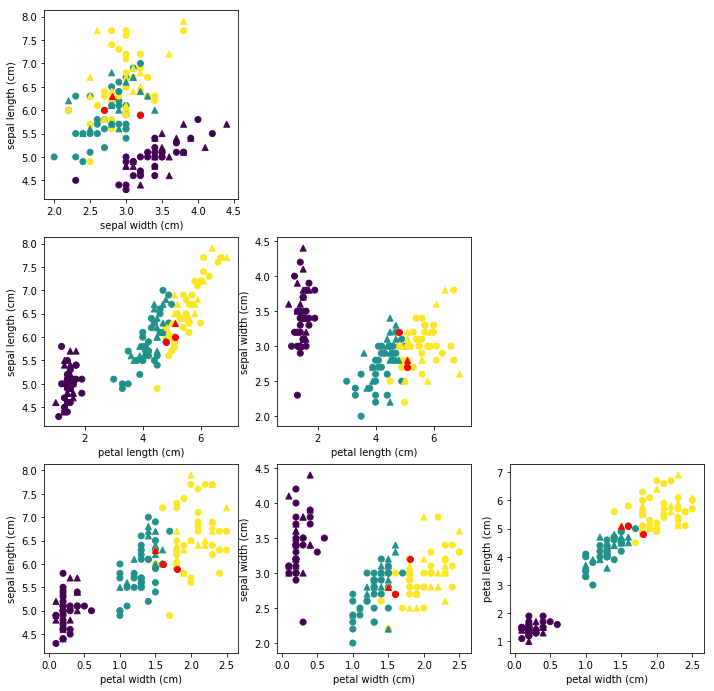

In [181]:
# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X_train[:,i],X_train[:,j],c=y_train)
            axs[i,j].scatter(X_test[:,i],X_test[:,j],c=y_test,marker='^')
            axs[i,j].plot(X_train[y_train!=y_pred,i],X_train[y_train!=y_pred,j],'ro')
            axs[i,j].plot(X_test[y_test!=y_pred_test,i],X_test[y_test!=y_pred_test,j],'r^')
            axs[i,j].set_xlabel(data['feature_names'][i])
            axs[i,j].set_ylabel(data['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.show()

Note that this is significantly better than naive Bayes!  

As a second example, let's return to the MNIST problem.  In particular, let's perform a PCA in exactly the same way as we did before.  This time, we'll use softmax regression rather than naive Bayes for the classification problem

In [95]:
from sklearn import datasets
from sklearn import decomposition
from sklearn import linear_model 

mnist = datasets.fetch_mldata('MNIST original')
X_train,X_test,y_train,y_test = train_test_split(mnist.data,mnist.target,test_size=0.33)

pca = decomposition.PCA(0.95,copy=True,whiten=True)
pca.fit(X_train)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

lm = linear_model.LogisticRegression(C=1e1,solver='lbfgs',multi_class='multinomial')
lm.fit(X_pca_train,y_train)

y_test_pred = lm.predict(X_pca_test)
c = confusion_matrix(y_test,y_test_pred)
accuracy = np.diagonal(c).sum()/c.sum()
print("Confusion matrix: \n",c)
print("Classification accuracy: ",accuracy)

y_train_pred = lm.predict(X_pca_train)
c = confusion_matrix(y_train,y_train_pred)
accuracy = np.diagonal(c).sum()/c.sum()
print("Confusion matrix: \n",c)
print("Classification accuracy: ",accuracy)


Confusion matrix: 
 [[2229    1   10    1    6   20   10    7   20    6]
 [   1 2486   12   11    2   11    1    1   18    2]
 [  10   27 2080   34   22   11   32   30   56    7]
 [   6   10   49 2088    0   90   11   15   41   22]
 [   5   13   16    5 2114    2   16   11   13   73]
 [  27   13   27   59   31 1832   40    7   54   14]
 [  16   13   21    0   19   30 2125    2    8    0]
 [   3   11   26   16   23    2    0 2219    5   85]
 [  11   51   27   56   13   76   29   13 1961   32]
 [  15   13    5   30   58   14    2   74   25 2103]]
Classification accuracy:  0.9193506493506494
Confusion matrix: 
 [[4462    0   18    9   10   36   30    4   21    3]
 [   0 5204   21   14    4   18    3   13   48    7]
 [  21   43 4250   62   50   25   65   44  103   18]
 [  18   18  105 4328    6  144   10   44   90   46]
 [  10   16   27    5 4252    2   43   17   30  154]
 [  43   14   37  127   38 3721   76   21  100   32]
 [  26   11   36    1   34   52 4453    4   23    2]
 [  10   18  

In [84]:
lm.C_

array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.,
       10000., 10000.])

(array([    9,    31,    34, ..., 23078, 23081, 23087]),)
7466
Classified as : 2.0
Actual class : 5.0


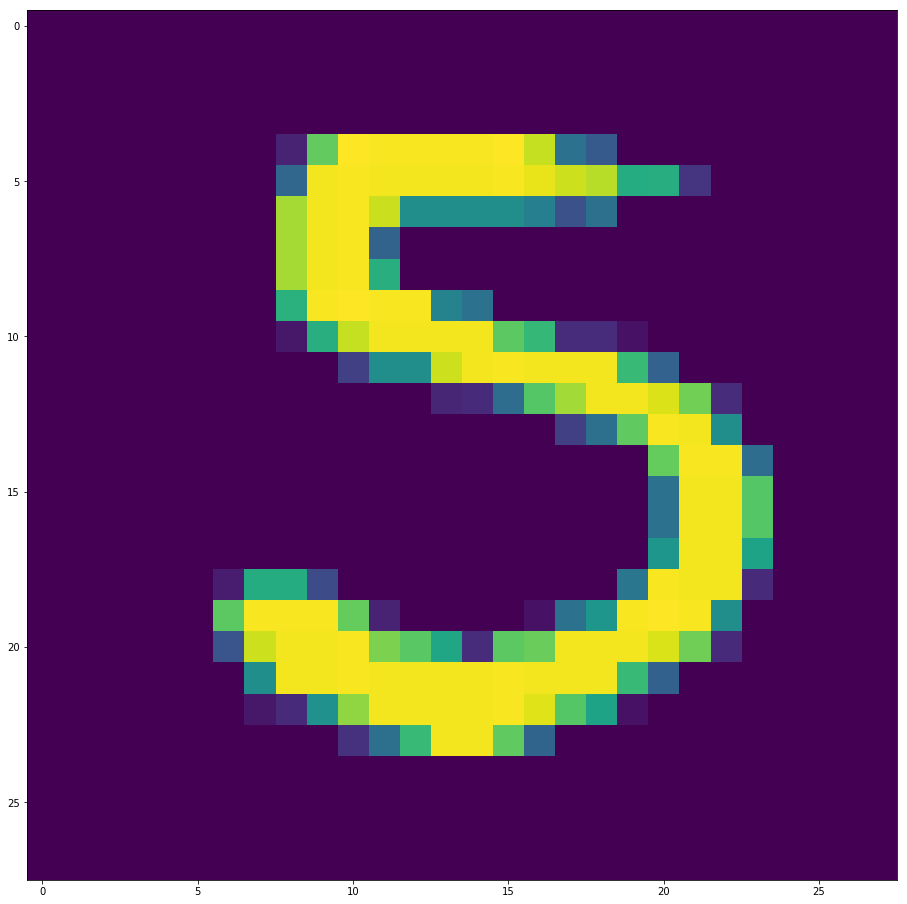

In [111]:
random_wrong_value = np.random.choice(np.where(y_test_pred!=y_test)[0])
print(np.where(y_test_pred!=y_test))
print(random_wrong_value)
fig,axs = plt.subplots(nrows=1,ncols=1)
axs.imshow(X_test[random_wrong_value].reshape((28,28)))
print("Classified as :",y_test_pred[random_wrong_value])
print("Actual class :",y_test[random_wrong_value])
plt.show()